In [1]:
import pandas as pd
import os

In [2]:
#Get the track ids from the audio files
tracks_id = []
root_path = r'../fma_small'
for path, subdirs, files in os.walk(root_path):
    for name in files:
        if name.endswith(".mp3"):
            tracks_id.append(name.split(".")[0])

In [3]:
len(tracks_id)

8000

In [4]:
#Get track information from raw_tracks.csv
raw_tracks = pd.read_csv("../fma_metadata/raw_tracks.csv")[["track_id", "track_genres"]]
print (raw_tracks.count())

track_id        109727
track_genres    107118
dtype: int64


In [5]:
#Shrink raw_tracks to get the genre for the 8k audio clips
final_track_list = raw_tracks[raw_tracks['track_id'].isin(tracks_id)]
print(final_track_list.count())

track_id        8000
track_genres    8000
dtype: int64


In [6]:
#Expand the genre nested dict to columns and rows
import json
new_tracks = pd.DataFrame(columns = ['track_id', 'genre_id', 'genre_title', 'genre_parent_id', 'genre_parent_title'])
for idx, row in final_track_list.iterrows():
    genres = json.loads(row['track_genres'].replace('\'','"'))
    for genre in genres:
        new_tracks = new_tracks.append({'track_id': row['track_id'], 'genre_id': int(genre['genre_id']), 'genre_title':genre['genre_title'] }, ignore_index=True)
        

In [7]:
new_tracks.head()

,track_id,genre_id,genre_title,genre_parent_id,genre_parent_title
0,2,21,Hip-Hop,NaN,NaN
1,5,21,Hip-Hop,NaN,NaN
2,10,10,Pop,NaN,NaN
3,140,17,Folk,NaN,NaN
4,141,17,Folk,NaN,NaN


In [8]:
new_tracks.count()

track_id              13246
genre_id              13246
genre_title           13246
genre_parent_id           0
genre_parent_title        0
dtype: int64

In [9]:
#Display the duplicated rows
new_tracks[new_tracks.duplicated('track_id')]

,track_id,genre_id,genre_title,genre_parent_id,genre_parent_title
54,825,45,Loud-Rock,NaN,NaN
55,825,58,Psych-Rock,NaN,NaN
56,825,66,Indie-Rock,NaN,NaN
148,3624,89,Post-Punk,NaN,NaN
152,3720,58,Psych-Rock,NaN,NaN
...,...,...,...,...,...
13237,154308,539,Rap,NaN,NaN
13238,154308,811,Hip-Hop Beats,NaN,NaN
13240,154309,539,Rap,NaN,NaN
13241,154309,811,Hip-Hop Beats,NaN,NaN


In [10]:
#Get the parent genres from raw_genre.csv
raw_genres = pd.read_csv("../fma_metadata/raw_genres.csv")[["genre_id", "genre_parent_id", "genre_title"]]

In [11]:
raw_genres.count()

genre_id           164
genre_parent_id    149
genre_title        164
dtype: int64

In [12]:
raw_genres[raw_genres['genre_id']==45]

,genre_id,genre_parent_id,genre_title
35,45,12.0,Loud-Rock


In [13]:
#Get the main genres - all other genres are subset of these
top_genres = raw_genres[raw_genres.genre_parent_id.isna()]
print(top_genres)

     genre_id  genre_parent_id          genre_title
1           2              NaN        International
2           3              NaN                Blues
3           4              NaN                 Jazz
4           5              NaN            Classical
7           8              NaN  Old-Time / Historic
8           9              NaN              Country
9          10              NaN                  Pop
11         12              NaN                 Rock
13         14              NaN             Soul-RnB
14         15              NaN           Electronic
16         17              NaN                 Folk
19         20              NaN               Spoken
20         21              NaN              Hip-Hop
31         38              NaN         Experimental
163      1235              NaN         Instrumental


In [14]:
raw_genres.count()

genre_id           164
genre_parent_id    149
genre_title        164
dtype: int64

In [15]:
#Remove the parent genres
raw_genres_updated = raw_genres[raw_genres.genre_parent_id.notna()]
raw_genres_updated.count()

genre_id           149
genre_parent_id    149
genre_title        149
dtype: int64

In [16]:
top_genres[top_genres['genre_id']==12].values[0][2]

'Rock'

In [17]:
#Get the parent genre IDs
for idx, row in new_tracks.iterrows():
    genre_row = raw_genres_updated[raw_genres_updated["genre_id"]==row["genre_id"]]
    
    if not genre_row.empty:
        if int(genre_row["genre_parent_id"]) in list(top_genres['genre_id']):
            row['genre_parent_id'] = int(genre_row["genre_parent_id"])
            row['genre_parent_title'] = top_genres[top_genres['genre_id']==row["genre_parent_id"]].values[0][2]
        else:
            row['genre_parent_id'] = None
            row['genre_parent_title'] = None
    else:
        row['genre_parent_id'] = row['genre_id']
        row['genre_parent_title'] = row.values[2]

In [18]:
new_tracks.count()

track_id              13246
genre_id              13246
genre_title           13246
genre_parent_id       11957
genre_parent_title    11957
dtype: int64

In [19]:
new_tracks.head()

,track_id,genre_id,genre_title,genre_parent_id,genre_parent_title
0,2,21,Hip-Hop,21,Hip-Hop
1,5,21,Hip-Hop,21,Hip-Hop
2,10,10,Pop,10,Pop
3,140,17,Folk,17,Folk
4,141,17,Folk,17,Folk


In [20]:
#Example:
#here the genre_id maps to genre_parent_id = 45 but 45 points back to 12. So i kept it as None and later drop it.

new_tracks[new_tracks['track_id']==3720]

,track_id,genre_id,genre_title,genre_parent_id,genre_parent_title
151,3720,53,Noise-Rock,None,None
152,3720,58,Psych-Rock,12,Rock


In [21]:
#Remove the None parent_genre_id rows (These are anyways duplicated) -> They are subset of same genre, as shown above
new_tracks = new_tracks[new_tracks.genre_parent_id.notna()]

In [22]:
new_tracks.count()

track_id              11957
genre_id              11957
genre_title           11957
genre_parent_id       11957
genre_parent_title    11957
dtype: int64

In [23]:
#print(new_tracks[new_tracks.duplicated('track_id')].head())

# Drop the duplicates 
new_tracks = new_tracks.drop_duplicates(subset=['track_id'])

In [24]:
new_tracks.count()

track_id              7714
genre_id              7714
genre_title           7714
genre_parent_id       7714
genre_parent_title    7714
dtype: int64

In [25]:
# Write to csv file
new_tracks.to_csv('./final_tracks.csv', index=False)

In [26]:
# Get all the genres
new_tracks['genre_parent_id'].value_counts()

21      1000
17      1000
10      1000
1235     996
15       970
38       932
2        910
12       906
Name: genre_parent_id, dtype: int64

In [27]:
#Check for the duplicated rows -> There are none
new_tracks[new_tracks.duplicated('track_id')]

,track_id,genre_id,genre_title,genre_parent_id,genre_parent_title


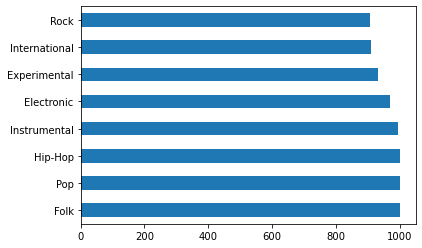

In [29]:
new_tracks['genre_parent_title'].value_counts()[:].plot(kind='barh')